## DSTRF

In [6]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
import numpy as np
import cv2
from PIL import Image
import yaml

from scipy.signal import resample, chirp
from sklearn.linear_model import Ridge, ElasticNet

import naplib as nl
from naplib.visualization import strf_plot
import pickle as pkl

In [7]:
import dynamic_strf as dstrf

In [8]:
import IPython.display as ipd

# from hdf5storage import loadmat

import torch
import torchaudio
import pytorch_lightning as plc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
torch.set_float32_matmul_precision("medium")
print(device)

cuda


In [9]:
with open("prep_response.npy", "rb") as f:
    small_response = np.load(f)
with open("prep_spec.npy", "rb") as f:
    spec = np.load(f)

with open("code_params.yaml", "r") as file:
    code_params = yaml.load(file, yaml.Loader)

In [ ]:
# define builder and trainer
from pytorch_lightning.loggers import TensorBoardLogger

# from pl_bolts.callbacks.printing import PrintTableMetricsCallback

tb_logger = TensorBoardLogger(
    f"{code_params['output_prefix']}/logs",
    name=f"{code_params['output_prefix'].replace('output/', '')}",
    log_graph=False,
)


def trainer():
    return plc.Trainer(
        accelerator="auto",
        precision="bf16-mixed",
        gradient_clip_val=10.0,
        max_epochs=code_params["max_epochs"],
        logger=tb_logger,
        log_every_n_steps=1,
        detect_anomaly=False,
        enable_model_summary=False,
        enable_progress_bar=True,
        enable_checkpointing=True,
        callbacks=[PrintTableMetricsCallback()],
    )


def builder():
    return dstrf.modeling.DeepEncoder(
        input_size=spec.shape[2],
        hidden_size=128,
        channels=small_response.shape[2],
    ).to(device)

In [ ]:
import os, yaml, ipynbname

os.system(
    f"jupyter nbconvert --to script thesis.ipynb --output-dir {code_params['output_prefix']}"
)

if __name__ == "__main__":
    print(code_params["animal_slices"])
    for animal_name, slice in code_params.keys(), code_params["animal_slices"].values():
        code_params['output_prefix'] += f"_{animal_name}"
        dstrf.modeling.fit_multiple(
			builder=builder,
			data=(spec[slice], small_response[slice]),
			batch_size=8,
			crossval=code_params["crossval"],
			jackknife=code_params["jackknife"],
			trainer=trainer,
			save_dir=f"{code_params['output_prefix']}/model",
			verbose=1,
    )

This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute the notebook prior to export.
    Equivalent to: [--ExecutePr

[NbConvertApp] WARNING | pattern 'thesis.ipynb' matched no files


In [8]:
# import glob, os
# checkpoints = sorted(glob.glob(os.path.join('output/5x128-jackknife-cv', 'model-*.pt')))
# print(checkpoints)

In [ ]:
raw_scores = {}
for animal_name, slice in code_params.keys(), code_params["animal_slices"].values():
    code_params['output_prefix'] += f"_{animal_name}"
    raw_scores[animal_name] = dstrf.modeling.test_multiple(
		model=builder(),
		checkpoints=f"{code_params['output_prefix']}/model",
		data=(spec[slice], small_response[slice]),
		crossval=code_params["crossval"],
		jackknife_mode="score",
		verbose=1
	)
    raw_scores.numpy()

MIOpen(HIP): Warning [IsEnoughWorkspace] [GetSolutionsFallback WTI] Solver <GemmFwdRest>, workspace required: 161280, provided ptr: 0 size: 0
MIOpen(HIP): Warning [IsEnoughWorkspace] [EvaluateInvokers] Solver <GemmFwdRest>, workspace required: 161280, provided ptr: 0 size: 0
MIOpen(HIP): Warning [IsEnoughWorkspace] [GetSolutionsFallback WTI] Solver <GemmFwdRest>, workspace required: 120320, provided ptr: 0 size: 0
MIOpen(HIP): Warning [IsEnoughWorkspace] [EvaluateInvokers] Solver <GemmFwdRest>, workspace required: 120320, provided ptr: 0 size: 0
MIOpen(HIP): Warning [IsEnoughWorkspace] [GetSolutionsFallback WTI] Solver <GemmFwdRest>, workspace required: 38400, provided ptr: 0 size: 0
MIOpen(HIP): Warning [IsEnoughWorkspace] [EvaluateInvokers] Solver <GemmFwdRest>, workspace required: 38400, provided ptr: 0 size: 0


array([[-1.4901161e-08,            nan, -3.7252903e-08, ...,
                   nan,            nan, -2.9802322e-08],
       [-1.4901161e-08,            nan,  2.9802322e-08, ...,
                   nan,            nan,  9.6857548e-08],
       [-1.4901161e-08,            nan,  1.4901161e-08, ...,
                   nan,            nan, -3.7252903e-08],
       ...,
       [ 2.2351742e-08,            nan, -7.4505806e-09, ...,
                   nan,            nan,  4.4703484e-08],
       [-2.9802322e-08,            nan, -3.7252903e-08, ...,
                   nan,            nan,  2.0489097e-08],
       [ 1.4901161e-08,            nan, -2.2351742e-08, ...,
                   nan,            nan,  2.2351742e-08]],
      shape=(18, 25840), dtype=float32)

0.99523187


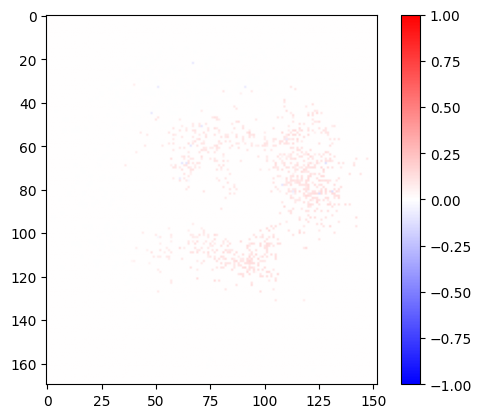

In [ ]:
from sklearn.preprocessing import normalize

for animal_name in code_params.keys():
	raw_scores[animal_name] = np.nan_to_num(raw_scores)
	scores = normalize(raw_scores[animal_name], axis=0)
	print(np.max(scores))
	scores = scores.reshape((-1, 170, 152))
	scores = np.mean(scores, axis=0)
	plt.imshow(scores, cmap="bwr", vmin=-1, vmax=1)

plt.colorbar()

In [ ]:
for animal_name, slice in code_params.keys(), code_params["animal_slices"].values():
    code_params['output_prefix'] += f"_{animal_name}"
    dstrf.estimate.dSTRF_multiple(
		model=builder(),
		checkpoints=f"{code_params['output_prefix']}/model",
		data=spec[0],
		crossval=code_params['crossval'],
		save_dir=f"{code_params['output_prefix']}/dstrf",
		chunk_size=1,
		verbose=1,
	)

Directory "output/170x152_90_trials/dstrf" already exists.
Found 1 model checkpoints in specified directory.
Computing dSTRFs for stimulus 01/01... 

 [████########################################################] 1/15 [05:13<05:13, 313.46s/it]

/home/cristi/.virtualenvs/base/lib64/python3.13/site-packages/dynamic_strf/estimate.py:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
MIOpen(HIP): Warning [IsEnoughWorkspace] [GetSolutionsFallback WTI] Solver <GemmFwdRest>, workspace required: 144640, provided ptr: 0 size: 0
MIOpen(HIP): Warning [IsEnoughWorkspace] [EvaluateInvokers] Solver <GemmFwdRest>, workspace required: 144640, provided ptr: 0 size: 0
MIOpen(HIP): Warning [IsEnoughWorkspace] [GetSolutionsFallback WTI] Solver <GemmFwdRest>, workspace required: 124160, provided ptr: 0 size: 0
MIOpen(HIP): Warning [IsEnoughWorkspace] [EvaluateInvokers] Solver <GemmFwdRest>, workspace required: 124160, provided ptr: 0 size: 0
MIOpen(HIP): Warning [IsEnoughWorkspace] [GetSolutionsFallback WTI] Solver <GemmFwdRest>, workspace required: 83200, provided ptr: 0 size: 0
MIOpen(HIP): Warning [IsEnoughWorkspace] [EvaluateInvokers]

KeyboardInterrupt: 

In [ ]:
code_params["estimated_channels"] = [20, 400, 20000]
for animal_name, slice in code_params.keys(), code_params["animal_slices"].values():
    code_params['output_prefix'] += f"_{animal_name}"
    dstrf.visualize.dSTRF(
		f"{code_params['output_prefix']}/dstrf/dSTRF-000.pt",
		channels=slice(0, None, 10000),
		time_range=slice(0, None, 1),
		output_prefix=f"{code_params['output_prefix']}",
		vcodec="libx264",
		xlabel="Time lag (ms)",
		xticks=[0, 65],
		xtick_labels=[code_params['max_lag'], 0],
		ylabel="Frequency",
		yticks=[0, 64],
		ytick_labels=["20Hz", "60KHz"],
		verbose=1
	)

ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with gcc 15 (GCC)
  configuration: --prefix=/usr --bindir=/usr/bin --datadir=/usr/share/ffmpeg --docdir=/usr/share/doc/ffmpeg --incdir=/usr/include/ffmpeg --libdir=/usr/lib64 --mandir=/usr/share/man --arch=x86_64 --optflags='-O2 -flto=auto -ffat-lto-objects -fexceptions -g -grecord-gcc-switches -pipe -Wall -Wno-complain-wrong-lang -Werror=format-security -Wp,-U_FORTIFY_SOURCE,-D_FORTIFY_SOURCE=3 -Wp,-D_GLIBCXX_ASSERTIONS -specs=/usr/lib/rpm/redhat/redhat-hardened-cc1 -fstack-protector-strong -specs=/usr/lib/rpm/redhat/redhat-annobin-cc1 -m64 -march=x86-64 -mtune=generic -fasynchronous-unwind-tables -fstack-clash-protection -fcf-protection -mtls-dialect=gnu2 -fno-omit-frame-pointer -mno-omit-leaf-frame-pointer' --extra-ldflags='-Wl,-z,relro -Wl,--as-needed -Wl,-z,pack-relative-relocs -Wl,-z,now -specs=/usr/lib/rpm/redhat/redhat-hardened-ld -specs=/usr/lib/rpm/redhat/redhat-annobin-cc1 -Wl,--build-id=sha1 -specs=/